In [1]:
from typing import List, Tuple, Dict
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from torch import load
from shapely import Point, Polygon
import rasterio
import geopandas as gpd
from Teknofest_backend.models import (
    dubois, 
    SoilMoisturePredictor)
from Teknofest_backend.utils.preprocessing import (
    free_outliers,
    ANGLE,
    get_weather_forecast, 
    get_field_sar,
    get_field_spec,
    get_water_required,
    update_map,
    format_spec,
    load_geojson,
    get_hectares
)
from Teknofest_backend.utils.postprocessing import (
    predict_soil_moisture,
    transform2rgb, 
    convert2image
)

# Initializing

In [2]:
MODEL_PATH = './Teknofest_backend/saved_models/model_cpu.pt'
PATH_IMAGE_DESCRIPTION = './Teknofest_backend/data/sentinel_data/fields'

In [3]:
class Processor():
    def __init__(self, field_id: int = 1, device: str = 'cpu'):
        self.field_id = field_id
        self.model = self.load_model().to(device)
        self.path_image_description = PATH_IMAGE_DESCRIPTION

    def load_model(self, model_path: str = MODEL_PATH):
        """Load Soil Moisture Predictor"""

        if model_path is None:
            model_path = MODEL_PATH

        checkpoints = load(model_path)
        model = SoilMoisturePredictor()
        model.load_state_dict(checkpoints)
        return model
        
    def update_field_id(self, field_id: int):
        self.field_id = field_id

    def get_spec(self) -> np.ndarray:
        """The function to generate spectrum with soil moisture map and save"""
        spec, src = get_field_spec(field_id=self.field_id, root=self.path_image_description)
        sm_map, sm, src = self.get_sm_map()
        poly = load_geojson(field_id=self.field_id, root=self.path_image_description)

        spec_formatted = format_spec(spec=spec, sm_map=sm_map, poly=poly, src=src)
        spec_image = convert2image(spec_formatted.transpose([1, 2, 0]))
        
        spec_image.save('./Teknofest_backend/images/field_{}.png'.format(self.field_id))

        insights = self.get_insights(sm=sm, poly=poly, src=src)

        return spec_image, insights
    
    def __predict(self) -> np.ndarray:
        _, temperature, precipitation = self.get_weather_forecast()
        soil_moisture_change = predict_soil_moisture(model=self.model, temperature=temperature, precipitation=precipitation)
        return soil_moisture_change
        
    def see_future(self) -> Tuple[List[float], List[float]]:
        sm, src = self.get_sm()
        sm_change = self.__predict()

        indexes = self.__get_indexes(sample=sm, src=src)
        
        water_required_total, water_required_per = get_water_required(soil_moisture_map=sm, indexes=indexes)

        water_totals = [water_required_total]
        water_pers = [water_required_per]
        for i in range(sm_change.size):
            sm = update_map(soil_moisture_map=sm, soil_moisture_change=sm_change[i])

            water_required_total, water_required_per = get_water_required(soil_moisture_map=sm, indexes=indexes)
            
            self.get_status_report(sm=sm)

            water_totals.append(water_required_total)
            water_pers.append(water_required_per)
        
        return water_totals, water_pers
    
    def get_insights(self, sm: np.ndarray, poly: Polygon, src: rasterio.io.DatasetReader):
        """Generating actionable insights based on Dubois-provided Map"""
        filepath = os.path.join(
            self.path_image_description, str(self.field_id), 'image_description', 'image_description.json'
            )
        
        data = json.load(open(filepath))
        
        indexes = self.__get_indexes(sample=sm, src=src)
        _, water_per = get_water_required(soil_moisture_map=sm, indexes=indexes)

        field_size = get_hectares(soil_moisture_map=sm, poly=poly, src=src)
        status = self.get_status_report(sm=sm)

        data['Hectare'].append('{} hectares'.format(field_size))
        data['Status'].append(status)

        if status == 'Bad':
            data['Problems'].append('Lack of water distribution')
            data['Recommendations'].append('{} kg/m^2 water is required'.format(round(water_per, 3)))

        else:
            data['Problems'].append('Water distribution is normal')
            data['Recommendations'].append('No irrigation is needed')
            
        return data

    def get_weather_forecast(self, days: int = 5) -> Tuple[List[str], List[float], List[float]]:
        return get_weather_forecast(field_id=self.field_id, days=days, root=self.path_image_description)

    def get_sm(self) -> np.ndarray:
        (vv, vh), src = get_field_sar(field_id=self.field_id, root=self.path_image_description)
        sm = dubois(vv=vv, vh=vh, angle=ANGLE)
        sm = free_outliers(sm[None], whis=1.5)[0]
        sm[sm < 0.2] = 0.2

        return sm, src
    
    def get_sm_map(self) -> np.ndarray:
        sm, src = self.get_sm()
        sm_map = transform2rgb(sm)
        return sm_map, sm, src
    
    def get_status_report(self, sm: np.ndarray) -> str:
        status = sm.mean()
      
        if status > 0.6:
            return 'Bad'

        elif status > 0.4:
            return 'Good'
        
        elif status > .3:
            return 'Normal'

        else:
            return 'Bad'
        
    def __get_indexes(self, sample: np.ndarray, src: rasterio.io.DatasetReader) -> np.ndarray:
        height, width = sample.shape
        poly = load_geojson(field_id=self.field_id, root=self.path_image_description)

        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    
        lons = np.array(xs)
        lats = np.array(ys)

        lons = lons.reshape(-1)
        lats = lats.reshape(-1)

        points = gpd.points_from_xy(lons, lats)
        indexes = np.where(points.within(poly))[0]
        return indexes

In [4]:
if __name__ == '__main__':
    
    # Create a processor for all the fields
    processor = Processor(device='cpu')

    # Provide field_id between 1 and 4
    processor.update_field_id(field_id=4)

    # The function saves an image that can be used in website.
    _, insights = processor.get_spec()
    
    # insights variable contains the information about Hectare, Problems, Status, and Recommendations
    print(insights.keys())
    print(insights)

    # The function returns 5-day weather forecasting by default. 
    # Datetime, temperature, and precipitation are returned
    date_time, temperature, precipitation = processor.get_weather_forecast(days=5)
    
    print('date_time:', date_time)
    print('temperature:', temperature)
    print('precipitation:', precipitation)

    # Those are the predicted required amount of water over the next 5-days.
    # water_totals --> total amount of water required for the field in kg
    # water_pers --> amount of water per m^2 for the field in kg/m^2
    water_totals, water_pers = processor.see_future()
    print('water total:', water_totals)
    print('water per:', water_pers)

dict_keys(['Problems', 'Status', 'Hectare', 'Recommendations'])
{'Problems': ['Nitrogen distribution is normal', 'Lack of water distribution'], 'Status': ['Bad'], 'Hectare': ['37.42 hectares'], 'Recommendations': ['No fertilization is needed', '4.016 kg/m^2 water is required']}
date_time: ['2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12', '2023-02-13']
temperature: [5.4, 4.4, 7.0, 8.2, 11.1]
precipitation: [0.0, 0.0, 0.0, 0.0, 0.0]
water total: [1502908.904843657, 1352866.0739119677, 1144633.208310517, 1123928.9927349314, 1186038.9801831718, 1471078.0948860208]
water per: [4.016325240095289, 3.6153556224264234, 3.058880834608544, 3.0035515572820186, 3.169532282691533, 3.9312616111331393]


# Analysis on Spectral and Dubois-generated Data

In [5]:
processor = Processor(device="cpu")

# You need to choose field_id among {1, 2, 3, 4}
processor.update_field_id(field_id=1)

# Get actionable insights while saving the generated image
spec_dubois, insights = processor.get_spec()

In [6]:
print(insights)

{'Problems': ['Nitrogen distribution is normal', 'Lack of water distribution'], 'Status': ['Bad'], 'Hectare': ['139.8 hectares'], 'Recommendations': ['No fertilization is needed', '5.75 kg/m^2 water is required']}


The variable insights given information Problems, Status (farm status), Hectare (farm area), Recommendations.

The status about nitrogen distribution is manually pre-defined to exhibit the idea. However, water status information is completely dynamic and rule-based.

In [7]:
print(insights["Problems"])

['Nitrogen distribution is normal', 'Lack of water distribution']


In [8]:
print(insights["Status"])

['Bad']


In [9]:
print(insights["Recommendations"])

['No fertilization is needed', '5.75 kg/m^2 water is required']


In [10]:
print(insights["Hectare"])

['139.8 hectares']


The farm, whose field id is 1, needs 5-6 kg of water per square of meter. This is general information about the farm. In the following, the visual map describes the case better with soil moisture distribution.

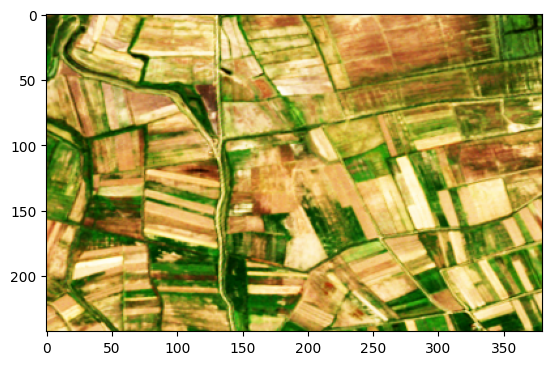

In [11]:
spec_orig, _ = get_field_spec(field_id=processor.field_id, root=processor.path_image_description)
spec_orig = convert2image(spec_orig.transpose([1, 2, 0]))
plt.imshow(spec_orig)

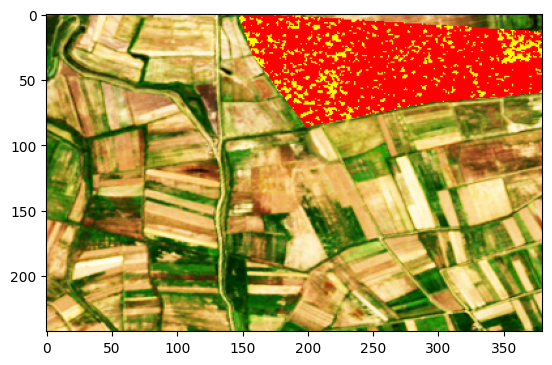

In [12]:
plt.imshow(spec_dubois)

The model predicts that most area are dry as indicated by red color distribution. Much fewer portion of the farm is more saturated.

## Field ID = 2

**Implementing the same for other fields.**

In [13]:
processor.update_field_id(field_id=2)
spec_dubois, insights = processor.get_spec()

In [14]:
print(insights["Problems"])

['Lack of nitrogen distribution', 'Lack of water distribution']


In [15]:
print(insights["Status"])

['Bad']


In [16]:
print(insights["Recommendations"])

['25.0 kg/hectare fertilization is required', '5.566 kg/m^2 water is required']


In [17]:
print(insights["Hectare"])

['63.65 hectares']


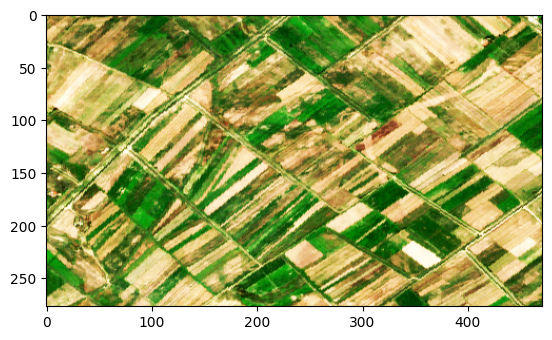

In [18]:
spec_orig, _ = get_field_spec(field_id=processor.field_id, root=processor.path_image_description)
spec_orig = convert2image(spec_orig.transpose([1, 2, 0]))
plt.imshow(spec_orig)

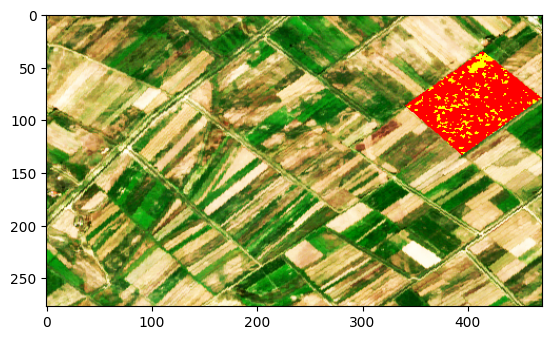

In [19]:
plt.imshow(spec_dubois)

## Field ID = 3

In [20]:
processor.update_field_id(field_id=3)
spec_dubois, insights = processor.get_spec()

In [21]:
print(insights["Problems"])

['Lack of nitrogen distribution', 'Lack of water distribution']


In [22]:
print(insights["Status"])

['Bad']


In [23]:
print(insights["Recommendations"])

['15.0 kg/hectare fertilization is required', '4.156 kg/m^2 water is required']


In [24]:
print(insights["Hectare"])

['147.57 hectares']


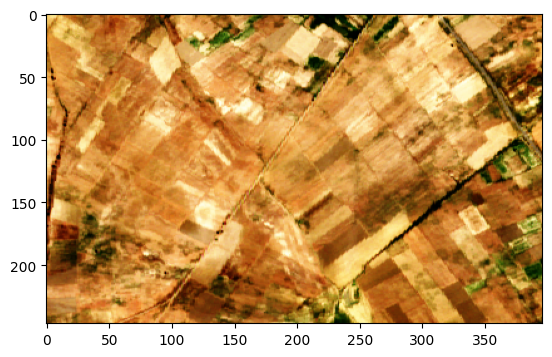

In [25]:
spec_orig, _ = get_field_spec(field_id=processor.field_id, root=processor.path_image_description)
spec_orig = convert2image(spec_orig.transpose([1, 2, 0]))
plt.imshow(spec_orig)

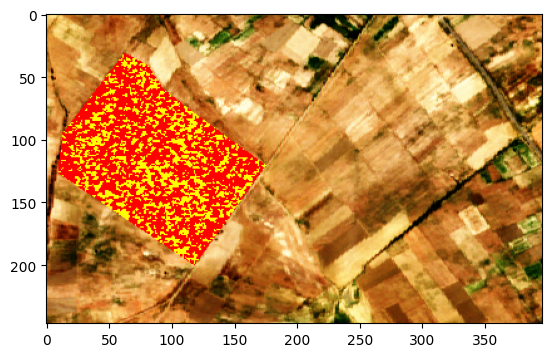

In [26]:
plt.imshow(spec_dubois)

## Field ID = 4

In [27]:
processor.update_field_id(field_id=4)
spec_dubois, insights = processor.get_spec()

In [28]:
print(insights["Problems"])

['Nitrogen distribution is normal', 'Lack of water distribution']


In [29]:
print(insights["Status"])

['Bad']


In [30]:
print(insights["Recommendations"])

['No fertilization is needed', '4.016 kg/m^2 water is required']


In [31]:
print(insights["Status"])

['Bad']


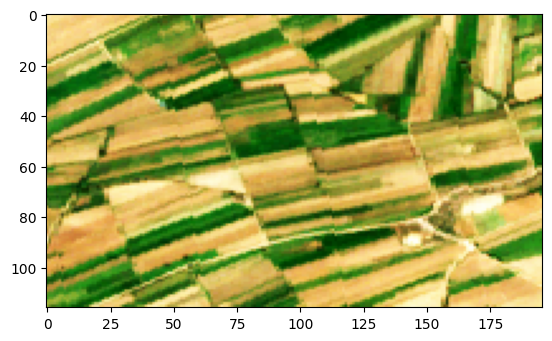

In [32]:
spec_orig, _ = get_field_spec(field_id=processor.field_id, root=processor.path_image_description)
spec_orig = convert2image(spec_orig.transpose([1, 2, 0]))
plt.imshow(spec_orig)

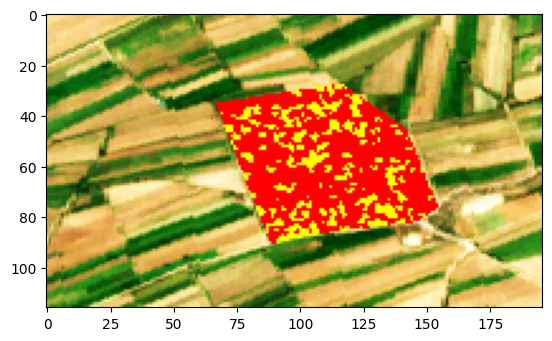

In [33]:
plt.imshow(spec_dubois)